In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import re
import pickle
from matplotlib import pyplot as plt
import sklearn
from sklearn import datasets, neighbors, linear_model, model_selection, svm
from sklearn.model_selection import train_test_split,KFold,learning_curve, LeavePOut,GridSearchCV

%matplotlib inline

In [2]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.utils as utils

## Feature Extraction

### Load Existing Data

In [3]:
def load_data(pickle_file):
    data = pd.read_pickle(pickle_file)
    # Split the data into training set and test set.
    # DONT look at what is in the test set
    test_patient_ids = ['2','32','24','24b','6','7', '41']
    test_data = data.loc[test_patient_ids]
    train_data = data.loc[data.index.difference(test_patient_ids)]
    return train_data, test_data

In [4]:
train_inception_concat, test_inception_concat = load_data('data_inception_cnn.pkl')
train_inception_diff, test_inception_diff = load_data('data_inception_cnn_diff.pkl')
train_reduced_dim, test_reduced_dim = load_data("data_inception_cnn_diff_reduced_dim.pkl")
train_reduced_dim_aug, test_reduced_dim_aug = load_data("data_inception_cnn_diff_reduced_dim_augmented.pkl")

#### Baseline

This baseline builds a feature set by pulling pairs of images and creating a difference of the image histograms they produce. The assumption is that files are contained in some input directory in the form patientX-1.jpg, patientX-2.jpg

In [5]:
X_concat = train_inception_concat.drop('y', axis=1)
y_concat = train_inception_concat["y"]

X_diff = train_inception_diff.drop('y', axis=1)
y_diff = train_inception_diff["y"]

X_reduced = train_reduced_dim.drop('y', axis=1)
y_reduced = train_reduced_dim["y"]

X_reduced_aug = train_reduced_dim_aug.drop('y', axis=1)
y_reduced_aug = train_reduced_dim_aug["y"]

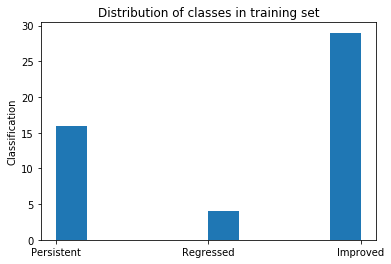

In [9]:
# Plot distribution of datapoints
# Suvadip suggested trying a binary classifier by combining regressed and persistent into one class.
# Then use ROC curve (used in binary classification) to evaluate model
plt.title('Distribution of classes in training set')
plt.ylabel('Classification')
ind = np.arange(3)
plt.xticks(ind, ('Persistent', 'Regressed','Improved'))
plt.hist(y_diff.tolist())
plt.show()

In [15]:
# This is based on recommendation from Suvadip. Leave one out is used for VERY small samples (size 15-20)
lpo = LeavePOut(3)

### KNN Classifier

In [6]:
def train_knn(X, y, multiclass, cv=LeavePOut(3), test_size=0.3):
    params = [{'n_neighbors': [2,3,4,5,6]}]
    knn = GridSearchCV(neighbors.KNeighborsClassifier(), cv=cv, param_grid = params)
    utils.do_CV(X,y, knn, multi_class=multiclass, test_size=test_size)
    return knn

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:

0.487 (+/-0.263) for {'n_neighbors': 2}
0.513 (+/-0.257) for {'n_neighbors': 3}
0.538 (+/-0.210) for {'n_neighbors': 4}
0.526 (+/-0.374) for {'n_neighbors': 5}
0.487 (+/-0.257) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.80      0.57      0.67         7
          R       0.50      0.71      0.59         7
          S       0.20      0.17      0.18         6

avg / total       0.52      0.50      0.49        20



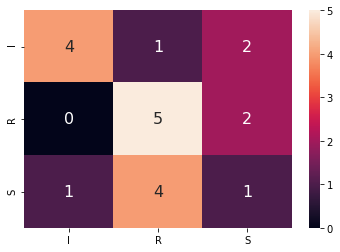

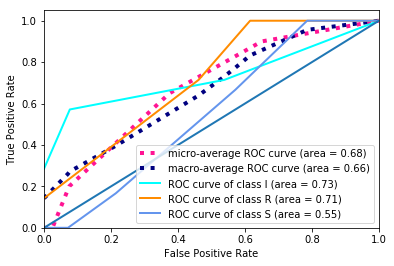


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.56      0.85      0.68        26
          R       0.70      0.62      0.65        26
          S       0.81      0.50      0.62        26

avg / total       0.69      0.65      0.65        78



In [7]:
# after stratifying
knn_model = train_knn(X_reduced_aug, y_reduced_aug, multiclass=True, cv=7, test_size=0.2)
pickle.dump(knn_model, open("knn_model.pkl", "wb"))

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 5}

Grid scores on development set:

0.355 (+/-0.545) for {'n_neighbors': 2}
0.374 (+/-0.550) for {'n_neighbors': 3}
0.437 (+/-0.565) for {'n_neighbors': 4}
0.448 (+/-0.568) for {'n_neighbors': 5}
0.393 (+/-0.553) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.47      0.73      0.57        11
          R       0.57      0.33      0.42        12
          S       0.67      0.57      0.62         7

avg / total       0.56      0.53      0.52        30


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.49      0.91      0.63        22
          R       0.75      0.43      0.55        21
          S       0.80      0.48      0.60        25

GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

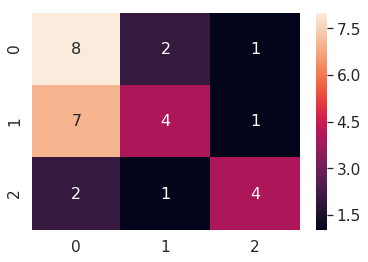

In [29]:
train_knn(X_reduced_aug, y_reduced_aug, True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.724 (+/-0.500) for {'n_neighbors': 2}
0.639 (+/-0.519) for {'n_neighbors': 3}
0.622 (+/-0.539) for {'n_neighbors': 4}
0.600 (+/-0.544) for {'n_neighbors': 5}
0.534 (+/-0.564) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       1.00      0.67      0.80        12
          R       0.20      1.00      0.33         1
          S       0.00      0.00      0.00         2

avg / total       0.81      0.60      0.66        15


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.77      1.00      0.87        17
          R       0.67      0.67      0.67         3
          S       1.00      0.64      0.78        14

GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

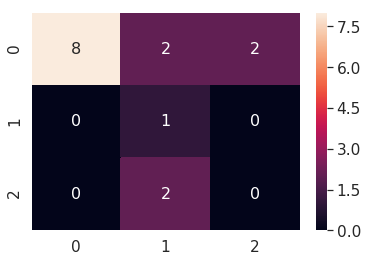

In [20]:
# EXTRA REDUCED
train_knn(X_reduced, y_reduced, True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.673 (+/-0.528) for {'n_neighbors': 2}
0.611 (+/-0.544) for {'n_neighbors': 3}
0.619 (+/-0.541) for {'n_neighbors': 4}
0.588 (+/-0.554) for {'n_neighbors': 5}
0.617 (+/-0.543) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.80      0.67      0.73        12
          R       0.25      1.00      0.40         1
          S       0.00      0.00      0.00         2

avg / total       0.66      0.60      0.61        15


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.74      1.00      0.85        17
          R       0.67      0.67      0.67         3
          S       1.00      0.57      0.73        14

GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

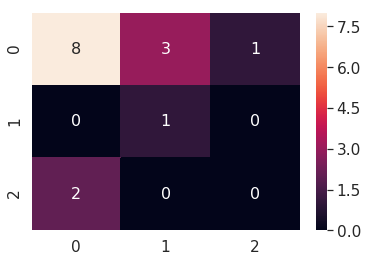

In [25]:
train_knn(X_reduced, y_reduced, True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.690 (+/-0.529) for {'n_neighbors': 2}
0.659 (+/-0.526) for {'n_neighbors': 3}
0.641 (+/-0.544) for {'n_neighbors': 4}
0.606 (+/-0.540) for {'n_neighbors': 5}
0.584 (+/-0.547) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.82      0.75      0.78        12
          R       0.33      1.00      0.50         1
          S       0.00      0.00      0.00         2

avg / total       0.68      0.67      0.66        15


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.77      1.00      0.87        17
          R       0.67      0.67      0.67         3
          S       1.00      0.64      0.78        14

GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

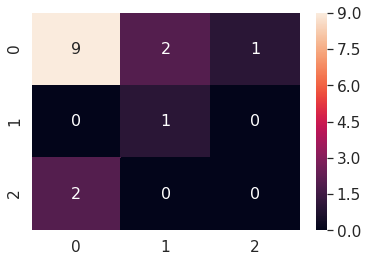

In [14]:
train_knn(X_diff, y_diff, True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.593 (+/-0.564) for {'n_neighbors': 2}
0.547 (+/-0.553) for {'n_neighbors': 3}
0.495 (+/-0.554) for {'n_neighbors': 4}
0.272 (+/-0.483) for {'n_neighbors': 5}
0.322 (+/-0.513) for {'n_neighbors': 6}
0.377 (+/-0.564) for {'n_neighbors': 7}
0.319 (+/-0.517) for {'n_neighbors': 8}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.75      0.50      0.60        12
          R       0.33      1.00      0.50         1
          S       0.00      0.00      0.00         2

avg / total       0.62      0.47      0.51        15

[[6 2 4]
 [0 1 0]
 [2 0 0]]



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

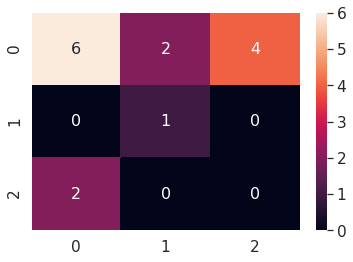

In [45]:
train_knn(X_concat, y_concat, True)

### KNN binary

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.618 (+/-0.205) for {'n_neighbors': 2}
0.691 (+/-0.225) for {'n_neighbors': 3}
0.662 (+/-0.197) for {'n_neighbors': 4}
0.588 (+/-0.226) for {'n_neighbors': 5}
0.647 (+/-0.214) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.33      0.40      0.36        10
          R       0.67      0.60      0.63        20

avg / total       0.56      0.53      0.54        30

ROC AUC score
0.5


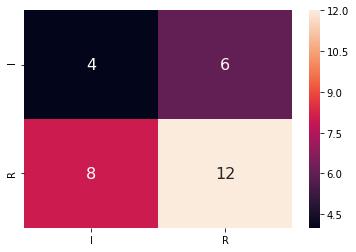

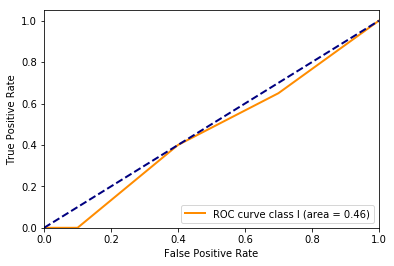


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.90      0.78      0.84        23
          R       0.90      0.96      0.92        45

avg / total       0.90      0.90      0.90        68



In [9]:
m = train_knn(X_reduced_aug, y_reduced_aug, multiclass=False, cv=5, test_size=0.3) # BAD MODEL

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 5}

Grid scores on development set:

0.472 (+/-0.570) for {'n_neighbors': 2}
0.592 (+/-0.558) for {'n_neighbors': 3}
0.557 (+/-0.572) for {'n_neighbors': 4}
0.626 (+/-0.553) for {'n_neighbors': 5}
0.535 (+/-0.567) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.56      0.45      0.50        11
          R       0.71      0.79      0.75        19

avg / total       0.66      0.67      0.66        30

ROC AUC score
0.622009569378

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.65      0.77      0.71        22
          R       0.88      0.80      0.84        46

avg / total       0.81      0.79      0.80        68



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

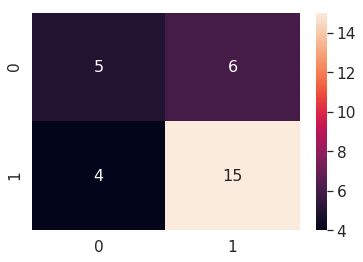

In [36]:
train_knn(X_reduced_aug, y_reduced_aug, False)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.752 (+/-0.478) for {'n_neighbors': 2}
0.727 (+/-0.481) for {'n_neighbors': 3}
0.701 (+/-0.519) for {'n_neighbors': 4}
0.682 (+/-0.521) for {'n_neighbors': 5}
0.586 (+/-0.562) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       1.00      0.67      0.80        12
          R       0.43      1.00      0.60         3

avg / total       0.89      0.73      0.76        15

ROC AUC score
0.833333333333

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.77      1.00      0.87        17
          R       1.00      0.71      0.83        17

avg / total       0.89      0.85      0.85        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

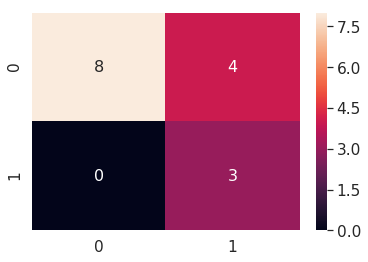

In [26]:
# extra reduced
train_knn(X_reduced, y_reduced, False)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.675 (+/-0.524) for {'n_neighbors': 2}
0.647 (+/-0.540) for {'n_neighbors': 3}
0.652 (+/-0.534) for {'n_neighbors': 4}
0.647 (+/-0.546) for {'n_neighbors': 5}
0.651 (+/-0.537) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.80      0.67      0.73        12
          R       0.20      0.33      0.25         3

avg / total       0.68      0.60      0.63        15

ROC AUC score
0.5

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.74      1.00      0.85        17
          R       1.00      0.65      0.79        17

avg / total       0.87      0.82      0.82        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

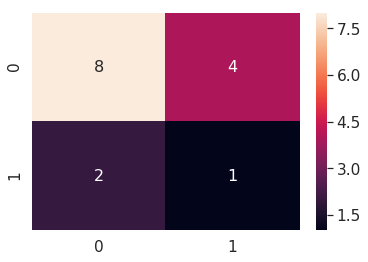

In [26]:
train_knn(X_reduced, y_reduced, False)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.699 (+/-0.514) for {'n_neighbors': 2}
0.695 (+/-0.518) for {'n_neighbors': 3}
0.671 (+/-0.534) for {'n_neighbors': 4}
0.665 (+/-0.524) for {'n_neighbors': 5}
0.636 (+/-0.536) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.82      0.75      0.78        12
          R       0.25      0.33      0.29         3

avg / total       0.70      0.67      0.68        15

ROC AUC score
0.541666666667

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.77      1.00      0.87        17
          R       1.00      0.71      0.83        17

avg / total       0.89      0.85      0.85        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

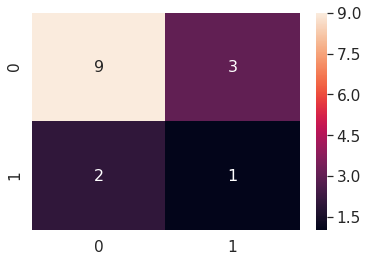

In [16]:
train_knn(X_diff, y_diff, False)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.662 (+/-0.543) for {'n_neighbors': 2}
0.652 (+/-0.543) for {'n_neighbors': 3}
0.603 (+/-0.528) for {'n_neighbors': 4}
0.433 (+/-0.529) for {'n_neighbors': 5}
0.515 (+/-0.537) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.75      0.50      0.60        12
          R       0.14      0.33      0.20         3

avg / total       0.63      0.47      0.52        15

ROC AUC score
0.416666666667

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.81      1.00      0.89        17
          R       1.00      0.76      0.87        17

avg / total       0.90      0.88      0.88        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

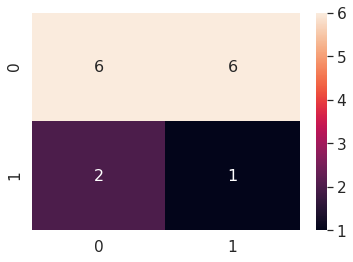

In [15]:
train_knn(X_concat, y_concat, False)

### Logistic Linear

In [25]:
def train_logistic(X,y, multiclass, cv=LeavePOut(3), test_size=0.3):
    params = [{'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}]
    lr = GridSearchCV(linear_model.LogisticRegression(solver='liblinear'), cv=cv, param_grid = params)
    if multiclass:
        params = [{'C': [0.001,0.01,0.1,1,10,100,1000]}]
        lr = GridSearchCV(linear_model.LogisticRegression(solver='lbfgs', penalty='l2', multi_class="multinomial", max_iter=3000), cv=cv, param_grid = params)
    utils.do_CV(X,y, lr, multi_class=multiclass, test_size=test_size)
    return lr

# Tuning hyper-parameter

Best parameters set found on development set:

{'penalty': 'l1', 'C': 1}

Grid scores on development set:

0.333 (+/-0.047) for {'penalty': 'l1', 'C': 0.001}
0.718 (+/-0.274) for {'penalty': 'l2', 'C': 0.001}
0.333 (+/-0.047) for {'penalty': 'l1', 'C': 0.01}
0.692 (+/-0.269) for {'penalty': 'l2', 'C': 0.01}
0.667 (+/-0.047) for {'penalty': 'l1', 'C': 0.1}
0.744 (+/-0.260) for {'penalty': 'l2', 'C': 0.1}
0.782 (+/-0.288) for {'penalty': 'l1', 'C': 1}
0.756 (+/-0.217) for {'penalty': 'l2', 'C': 1}
0.756 (+/-0.181) for {'penalty': 'l1', 'C': 10}
0.756 (+/-0.171) for {'penalty': 'l2', 'C': 10}
0.782 (+/-0.143) for {'penalty': 'l1', 'C': 100}
0.744 (+/-0.165) for {'penalty': 'l2', 'C': 100}
0.769 (+/-0.173) for {'penalty': 'l1', 'C': 1000}
0.744 (+/-0.165) for {'penalty': 'l2', 'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score

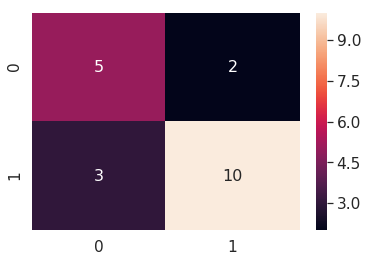

In [26]:
# AFTER STRATIFY
lr = train_logistic(X_reduced_aug, y_reduced_aug, False, cv=7, test_size=0.2)
pickle.dump(lr, open("lr_binary_reduced_model_aug.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'penalty': 'l1'}

Grid scores on development set:

0.324 (+/-0.047) for {'C': 0.001, 'penalty': 'l1'}
0.647 (+/-0.210) for {'C': 0.001, 'penalty': 'l2'}
0.324 (+/-0.047) for {'C': 0.01, 'penalty': 'l1'}
0.676 (+/-0.278) for {'C': 0.01, 'penalty': 'l2'}
0.500 (+/-0.356) for {'C': 0.1, 'penalty': 'l1'}
0.662 (+/-0.269) for {'C': 0.1, 'penalty': 'l2'}
0.706 (+/-0.218) for {'C': 1, 'penalty': 'l1'}
0.691 (+/-0.187) for {'C': 1, 'penalty': 'l2'}
0.750 (+/-0.225) for {'C': 10, 'penalty': 'l1'}
0.721 (+/-0.296) for {'C': 10, 'penalty': 'l2'}
0.750 (+/-0.229) for {'C': 100, 'penalty': 'l1'}
0.735 (+/-0.287) for {'C': 100, 'penalty': 'l2'}
0.750 (+/-0.225) for {'C': 1000, 'penalty': 'l1'}
0.735 (+/-0.287) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-scor

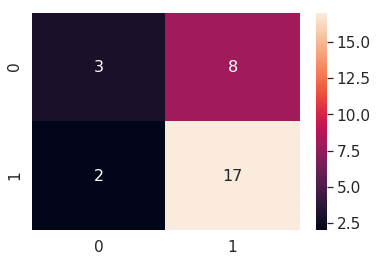

In [34]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, False, 7)
pickle.dump(lr, open("lr_binary_reduced_model_aug.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1, 'penalty': 'l1'}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.001, 'penalty': 'l1'}
0.532 (+/-0.549) for {'C': 0.001, 'penalty': 'l2'}
0.500 (+/-0.560) for {'C': 0.01, 'penalty': 'l1'}
0.534 (+/-0.544) for {'C': 0.01, 'penalty': 'l2'}
0.500 (+/-0.560) for {'C': 0.1, 'penalty': 'l1'}
0.531 (+/-0.543) for {'C': 0.1, 'penalty': 'l2'}
0.598 (+/-0.564) for {'C': 1, 'penalty': 'l1'}
0.520 (+/-0.542) for {'C': 1, 'penalty': 'l2'}
0.540 (+/-0.550) for {'C': 10, 'penalty': 'l1'}
0.527 (+/-0.542) for {'C': 10, 'penalty': 'l2'}
0.520 (+/-0.530) for {'C': 100, 'penalty': 'l1'}
0.531 (+/-0.552) for {'C': 100, 'penalty': 'l2'}
0.523 (+/-0.540) for {'C': 1000, 'penalty': 'l1'}
0.536 (+/-0.560) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score

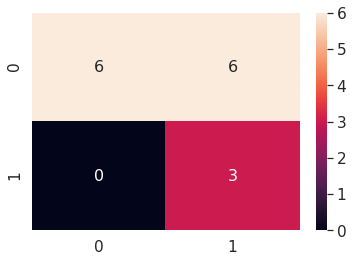

In [24]:
# extra reduced
lr = train_logistic(X_reduced, y_reduced, False)
pickle.dump(lr, open("lr_binary_reduced_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1000, 'penalty': 'l2'}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.001, 'penalty': 'l1'}
0.578 (+/-0.561) for {'C': 0.001, 'penalty': 'l2'}
0.500 (+/-0.560) for {'C': 0.01, 'penalty': 'l1'}
0.597 (+/-0.551) for {'C': 0.01, 'penalty': 'l2'}
0.500 (+/-0.560) for {'C': 0.1, 'penalty': 'l1'}
0.576 (+/-0.544) for {'C': 0.1, 'penalty': 'l2'}
0.549 (+/-0.525) for {'C': 1, 'penalty': 'l1'}
0.583 (+/-0.544) for {'C': 1, 'penalty': 'l2'}
0.543 (+/-0.508) for {'C': 10, 'penalty': 'l1'}
0.594 (+/-0.546) for {'C': 10, 'penalty': 'l2'}
0.566 (+/-0.538) for {'C': 100, 'penalty': 'l1'}
0.605 (+/-0.549) for {'C': 100, 'penalty': 'l2'}
0.594 (+/-0.540) for {'C': 1000, 'penalty': 'l1'}
0.618 (+/-0.554) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-sc

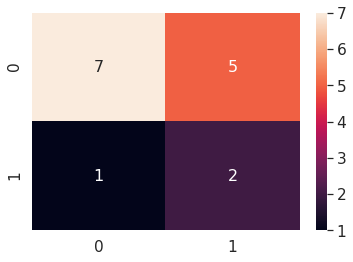

In [27]:
lr = train_logistic(X_reduced, y_reduced, False)
pickle.dump(lr, open("lr_binary_reduced_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 100, 'penalty': 'l1'}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.001, 'penalty': 'l1'}
0.588 (+/-0.561) for {'C': 0.001, 'penalty': 'l2'}
0.500 (+/-0.560) for {'C': 0.01, 'penalty': 'l1'}
0.583 (+/-0.544) for {'C': 0.01, 'penalty': 'l2'}
0.500 (+/-0.560) for {'C': 0.1, 'penalty': 'l1'}
0.567 (+/-0.543) for {'C': 0.1, 'penalty': 'l2'}
0.593 (+/-0.541) for {'C': 1, 'penalty': 'l1'}
0.558 (+/-0.538) for {'C': 1, 'penalty': 'l2'}
0.630 (+/-0.558) for {'C': 10, 'penalty': 'l1'}
0.553 (+/-0.531) for {'C': 10, 'penalty': 'l2'}
0.656 (+/-0.548) for {'C': 100, 'penalty': 'l1'}
0.557 (+/-0.532) for {'C': 100, 'penalty': 'l2'}
0.654 (+/-0.546) for {'C': 1000, 'penalty': 'l1'}
0.564 (+/-0.531) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-sco

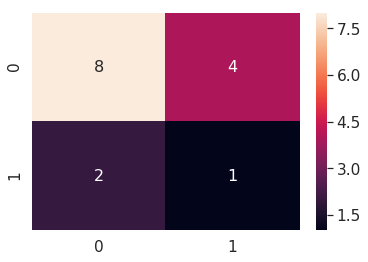

In [18]:
lr = train_logistic(X_diff, y_diff, False)
pickle.dump(lr, open("lr_binary_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'penalty': 'l1'}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.001, 'penalty': 'l1'}
0.582 (+/-0.555) for {'C': 0.001, 'penalty': 'l2'}
0.500 (+/-0.560) for {'C': 0.01, 'penalty': 'l1'}
0.645 (+/-0.538) for {'C': 0.01, 'penalty': 'l2'}
0.375 (+/-0.506) for {'C': 0.1, 'penalty': 'l1'}
0.677 (+/-0.524) for {'C': 0.1, 'penalty': 'l2'}
0.705 (+/-0.512) for {'C': 1, 'penalty': 'l1'}
0.664 (+/-0.511) for {'C': 1, 'penalty': 'l2'}
0.720 (+/-0.524) for {'C': 10, 'penalty': 'l1'}
0.659 (+/-0.513) for {'C': 10, 'penalty': 'l2'}
0.688 (+/-0.518) for {'C': 100, 'penalty': 'l1'}
0.658 (+/-0.514) for {'C': 100, 'penalty': 'l2'}
0.657 (+/-0.504) for {'C': 1000, 'penalty': 'l1'}
0.654 (+/-0.517) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-scor

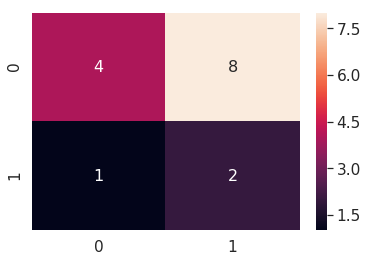

In [20]:
lr = train_logistic(X_concat, y_concat, False)
pickle.dump(lr, open("lr_binary_concat_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1000, 'penalty': 'l1'}

Grid scores on development set:

0.503 (+/-0.558) for {'C': 0.001, 'penalty': 'l1'}
0.464 (+/-0.558) for {'C': 0.001, 'penalty': 'l2'}
0.527 (+/-0.562) for {'C': 0.01, 'penalty': 'l1'}
0.467 (+/-0.556) for {'C': 0.01, 'penalty': 'l2'}
0.519 (+/-0.568) for {'C': 0.1, 'penalty': 'l1'}
0.468 (+/-0.558) for {'C': 0.1, 'penalty': 'l2'}
0.497 (+/-0.565) for {'C': 1, 'penalty': 'l1'}
0.468 (+/-0.558) for {'C': 1, 'penalty': 'l2'}
0.490 (+/-0.567) for {'C': 10, 'penalty': 'l1'}
0.468 (+/-0.557) for {'C': 10, 'penalty': 'l2'}
0.531 (+/-0.556) for {'C': 100, 'penalty': 'l1'}
0.468 (+/-0.558) for {'C': 100, 'penalty': 'l2'}
0.547 (+/-0.564) for {'C': 1000, 'penalty': 'l1'}
0.468 (+/-0.557) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-s

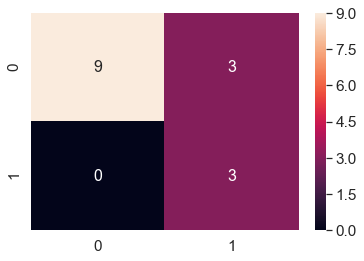

In [66]:
# THIS IS OUTPUT FROM THE HISTOGRAM data (binary)

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10}

Grid scores on development set:

0.500 (+/-0.220) for {'C': 0.001}
0.423 (+/-0.183) for {'C': 0.01}
0.397 (+/-0.243) for {'C': 0.1}
0.474 (+/-0.248) for {'C': 1}
0.513 (+/-0.291) for {'C': 10}
0.513 (+/-0.291) for {'C': 100}
0.513 (+/-0.291) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       1.00      0.71      0.83         7
          R       0.60      0.43      0.50         7
          S       0.40      0.67      0.50         6

avg / total       0.68      0.60      0.62        20


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        26
          R       1.00      1.00      1.00        26
          S       1.00      1.00    

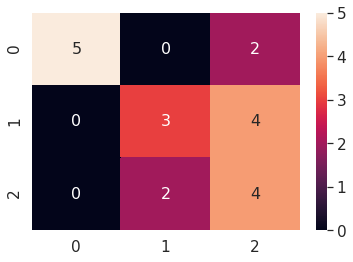

In [28]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, True, cv=7, test_size=0.2)
pickle.dump(lr, open("lr_binary_reduced_model_aug_strat.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1000}

Grid scores on development set:

0.217 (+/-0.453) for {'C': 0.001}
0.247 (+/-0.486) for {'C': 0.01}
0.330 (+/-0.546) for {'C': 0.1}
0.460 (+/-0.568) for {'C': 1}
0.489 (+/-0.573) for {'C': 10}
0.495 (+/-0.569) for {'C': 100}
0.497 (+/-0.568) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       1.00      0.36      0.53        11
          R       1.00      0.50      0.67        12
          S       0.35      1.00      0.52         7

avg / total       0.85      0.57      0.58        30


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        22
          R       1.00      1.00      1.00        21
          S       1.00      1.00  

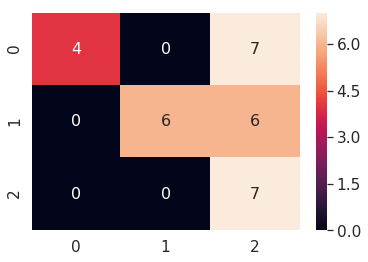

In [35]:
lr2 = train_logistic(X_reduced_aug, y_reduced_aug, True, 7)
pickle.dump(lr2, open("lr_multi_reduced_model_aug.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1}

Grid scores on development set:

0.444 (+/-0.469) for {'C': 0.001}
0.400 (+/-0.544) for {'C': 0.01}
0.444 (+/-0.553) for {'C': 0.1}
0.456 (+/-0.538) for {'C': 1}
0.449 (+/-0.546) for {'C': 10}
0.447 (+/-0.548) for {'C': 100}
0.443 (+/-0.546) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       1.00      0.67      0.80        12
          R       0.33      1.00      0.50         1
          S       0.25      0.50      0.33         2

avg / total       0.86      0.67      0.72        15


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        17
          R       1.00      1.00      1.00         3
          S       1.00      1.00     

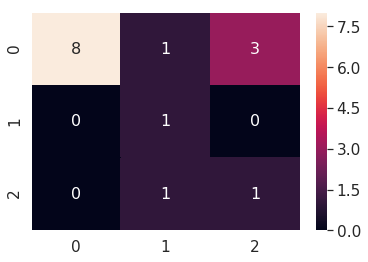

In [25]:
# extra reduced
lr2 = train_logistic(X_reduced, y_reduced, True)

pickle.dump(lr2, open("lr_multi_model_reduced.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.01}

Grid scores on development set:

0.466 (+/-0.540) for {'C': 0.001}
0.570 (+/-0.556) for {'C': 0.01}
0.536 (+/-0.542) for {'C': 0.1}
0.536 (+/-0.555) for {'C': 1}
0.528 (+/-0.557) for {'C': 10}
0.520 (+/-0.553) for {'C': 100}
0.502 (+/-0.548) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.77      0.83      0.80        12
          R       0.00      0.00      0.00         1
          S       0.00      0.00      0.00         2

avg / total       0.62      0.67      0.64        15


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.80      0.94      0.86        17
          R       0.00      0.00      0.00         3
          S       0.86      0.86  

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


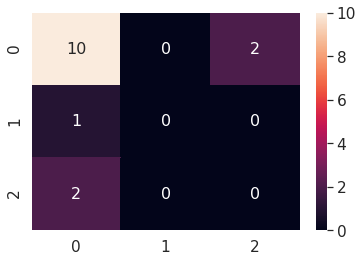

In [29]:
lr2 = train_logistic(X_reduced, y_reduced, True)

pickle.dump(lr2, open("lr_multi_model_reduced.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.01}

Grid scores on development set:

0.502 (+/-0.587) for {'C': 0.001}
0.545 (+/-0.543) for {'C': 0.01}
0.517 (+/-0.559) for {'C': 0.1}
0.504 (+/-0.557) for {'C': 1}
0.495 (+/-0.554) for {'C': 10}
0.492 (+/-0.550) for {'C': 100}
0.493 (+/-0.565) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.83      0.83      0.83        12
          R       1.00      1.00      1.00         1
          S       0.00      0.00      0.00         2

avg / total       0.73      0.73      0.73        15


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.89      0.94      0.91        17
          R       1.00      0.33      0.50         3
          S       0.87      0.93  

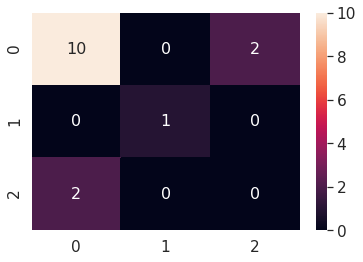

In [19]:
lr2 = train_logistic(X_diff, y_diff, True)

pickle.dump(lr2, open("lr_multi_model_diff.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.01}

Grid scores on development set:

0.534 (+/-0.574) for {'C': 0.001}
0.541 (+/-0.558) for {'C': 0.01}
0.536 (+/-0.557) for {'C': 0.1}
0.513 (+/-0.548) for {'C': 1}
0.516 (+/-0.553) for {'C': 10}
0.524 (+/-0.562) for {'C': 100}
0.520 (+/-0.562) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       0.86      0.50      0.63        12
          R       0.00      0.00      0.00         1
          S       0.12      0.50      0.20         2

avg / total       0.70      0.47      0.53        15


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.94      0.94      0.94        17
          R       0.00      0.00      0.00         3
          S       0.76      0.93  

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


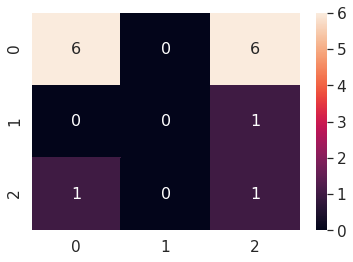

In [21]:
lr2 = train_logistic(X_concat, y_concat, True)

pickle.dump(lr2, open("lr_multi_concat_model_diff.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1}

Grid scores on development set:

0.402 (+/-0.538) for {'C': 0.001}
0.410 (+/-0.552) for {'C': 0.01}
0.412 (+/-0.552) for {'C': 0.1}
0.413 (+/-0.553) for {'C': 1}
0.398 (+/-0.547) for {'C': 10}
0.393 (+/-0.543) for {'C': 100}
0.395 (+/-0.543) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           I       0.71      0.42      0.53        12
           R       0.25      1.00      0.40         1
           S       0.00      0.00      0.00         2

   micro avg       0.40      0.40      0.40        15
   macro avg       0.32      0.47      0.31        15
weighted avg       0.59      0.40      0.45        15




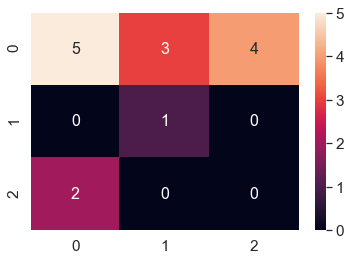

In [76]:
# THIS IS OUTPUT FROM THE HISTOGRAM data (multiclass)

### SVM: Note that these all just give 100% improved

In [8]:
params = [{'C': [0.1,10,100, 1000], 'gamma': [0.1,1,10,100, 1000]}]
sv = GridSearchCV(svm.SVC(), cv=lpo, param_grid = params)
utils.do_CV(X,y, sv, multi_class=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.1, 'gamma': 0.1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 10}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 100}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 10, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 10}
0.555 (+/-0.557) for {'C': 10, 'gamma': 100}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 100, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 10}
0.555 (+/-0.557) for {'C': 100, 'gamma': 100}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 10}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 100}
0.555

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.1, 'gamma': 0.1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 10}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 100}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 10, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 10}
0.555 (+/-0.557) for {'C': 10, 'gamma': 100}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 100, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 10}
0.555 (+/-0.557) for {'C': 100, 'gamma': 100}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 10}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 100}
0.555

/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


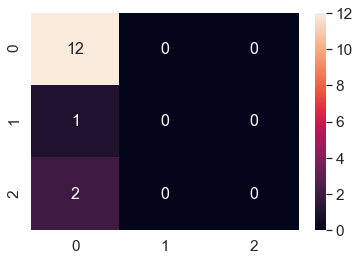

In [74]:
params = [{'C': [0.1,10,100, 1000], 'gamma': [0.1,1,10,100, 1000]}]
sv = GridSearchCV(svm.SVC(), cv=lpo, param_grid = params)
utils.do_CV(X,y, sv, multi_class=True)

### This can be ignored for now

In [7]:
def plot_learning_curve(model, X,y, cv):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y,
                                                            train_sizes=[5,10,15,20,25,30,35,40,45,48],
                                                            cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

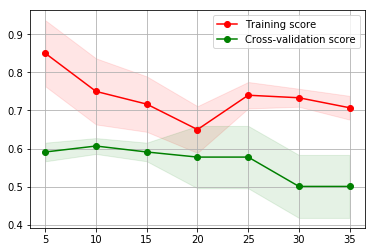

In [49]:
plot_learning_curve(knn, X,y, 4)

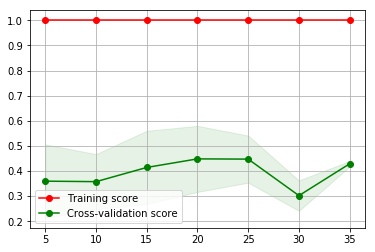

In [51]:
plot_learning_curve(logistic, X,y, 3)

In [ ]:
#pytorch
#pretrained embeddings
# extract a feature vector for any image with pytorch

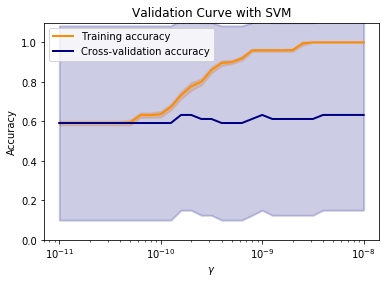

In [5]:
loo = model_selection.LeaveOneOut()
param_range = np.logspace(-11, -8, 31)

utils.generate_validation_curve(svm.SVC(), X, y, param_name="gamma", param_range=param_range,
                                cv=loo, scoring="accuracy", n_jobs=-1,
                                title="Validation Curve with SVM", xlabel="$\gamma$")

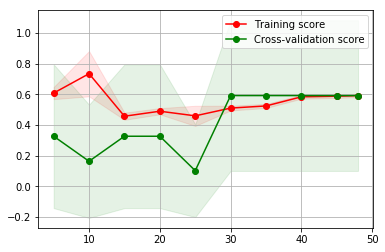

In [8]:
svm_classifier = svm.SVC(gamma=1e-11)
plot_learning_curve(svm_classifier, X,y, cv=loo)

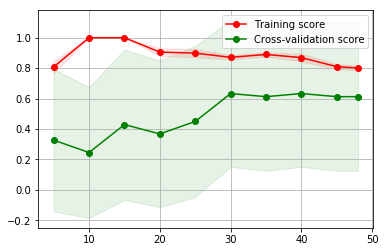

In [9]:
svm_classifier = svm.SVC(gamma=2.51188643e-10)
plot_learning_curve(svm_classifier, X,y, cv=loo)

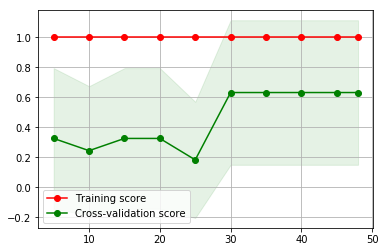

In [10]:
svm_classifier = svm.SVC(gamma=1e-8)
plot_learning_curve(svm_classifier, X,y, cv=loo)